![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FFramework+Workflows%2FKeras&file=Keras+With+JAX+Overview.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Framework%20Workflows/Keras/Keras%20With%20JAX%20Overview.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FFramework%2520Workflows%2FKeras%2FKeras%2520With%2520JAX%2520Overview.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Framework%20Workflows/Keras/Keras%20With%20JAX%20Overview.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Framework%20Workflows/Keras/Keras%20With%20JAX%20Overview.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Keras Overview

An overview of using Keras 3 for building an autoencoder and its application in anomaly detection.

This overview demonstrates how to build, train, and deploy an autoencoder for anomaly detection using Keras 3, with a focus on:

*   Leveraging the **JAX backend** for numerical computation.
*   Creating a robust and portable model suitable for **TensorFlow Serving**.
*   Structuring the model for clear outputs and easy analysis.
*   Handling data preprocessing and feature engineering within the Keras workflow.

## Core Concepts

**Keras 3:** A high-level API for building and training neural networks. Keras 3 offers multi-backend support, allowing you to use the same Keras code with TensorFlow, JAX, or PyTorch.

**JAX:** A numerical computation library from Google that excels at automatic differentiation and acceleration on GPUs and TPUs. Using JAX as the Keras backend can lead to significant performance improvements, especially for models with custom operations or complex gradient calculations.

**Autoencoders:** A type of neural network trained to *reconstruct* its input.  An autoencoder consists of two main parts:
    *   **Encoder:** Compresses the input data into a lower-dimensional "latent space" representation.
    *   **Decoder:** Reconstructs the original input from the latent space representation.

**Anomaly Detection:** The principle is that anomalies (data points that deviate significantly from the norm) will have *higher reconstruction errors* than normal data points.  By training the autoencoder on "normal" data, we can use the reconstruction error as a measure of "anomalousness."

**TensorFlow Serving:** A flexible, high-performance serving system for machine learning models, designed for production environments. Keras 3 models can be easily exported to the TensorFlow SavedModel format, which is directly compatible with TensorFlow Serving.

**TensorFlow Datasets (`tf.data`)**: An efficient API for building input pipelines, particularly well-suited for large datasets.

## Workflow Summary

This workflow covers the following key steps:

1.  **Data Loading and Preprocessing:**
    *   Loading data from BigQuery using the `google-cloud-bigquery` library.
    *   Converting the data to a `tf.data.Dataset` for efficient batching and prefetching.
    *   Defining preprocessing steps:
        *   Removing irrelevant columns (`transaction_id`).
        *   Identifying the target variable (`Class`).
        *   Identifying numerical features.
        *   Creating `Normalization` layers (`normalizer` and `denormalizer`) for feature scaling.  These layers are adapted to the training data.
    *   Creating a `prep_batch` function to prepare batches of data for the model.

2.  **Autoencoder Model Definition:**
    *   Defining the `autoencoder` model using the Keras Functional API.  This includes an encoder (with `Dense` and `Dropout` layers) and a decoder, with a `latent` layer representing the compressed representation.
    *   Using a custom loss function (`custom_loss`) based on Mean Absolute Error (MAE), implemented using JAX's NumPy (`jnp`).
    *   Compiling the `autoencoder` with an optimizer (Adam) and metrics (RMSE, MSE, MAE, MSLE).

3.  **Autoencoder Training:**
    *   Training the `autoencoder` using the prepared `train_dataset` and `val_dataset`.
    *   Using `EarlyStopping` to prevent overfitting (optional, but good practice).

4.  **Encoder Model Creation:**
    *   Creating a separate `encoder_model` from the trained `autoencoder` to extract the latent space representation. This uses `keras.Model` with the `autoencoder`'s input and the `latent` layer's output.

5.  **`PostProcessingLayer` (Custom Layer):**
    *   Defining a custom Keras layer, `PostProcessingLayer`, to encapsulate all the post-processing logic *within* the model graph. This layer:
        *   Takes the trained `autoencoder`, `encoder_model`, `normalizer`, and `denormalizer` as inputs.
        *   Performs normalization, autoencoding, denormalization, *and* latent space extraction.
        *   Calculates reconstruction errors and metrics (MAE, RMSE, MSE, MSLE) *per instance*, aggregated across features.  Uses JAX (`jnp`) for these calculations.
        *   Returns a dictionary containing:
            *   `normalized_reconstruction`: The reconstructed output (normalized).
            *   `normalized_reconstruction_errors`:  The difference between the normalized input and reconstruction.
            *   `normalized_metrics`:  MAE, RMSE, MSE, and MSLE calculated on the normalized data.
            *   `denormalized_reconstruction`:  The reconstructed output, denormalized back to the original scale.
            *   `denormalized_reconstruction_errors`: The difference between the original (denormalized) input and the denormalized reconstruction.
            *   `denormalized_metrics`: MAE, RMSE, MSE, and MSLE calculated on the denormalized data.
            *   `encoded`: The output of the `encoder_model` (the latent space representation).
        * For the TF Serving Model, a `PostProcessingLayerTF` is created to return a *flattened* dictionary, for compatiability.

6. **Keras `final_model` Definition:**
      * A separate `final_model` is created.
      *   Takes a single tensor input (representing the stacked numerical features).
        *   Passes the input to the `PostProcessingLayer`.
        *   Returns the structured dictionary output from the `PostProcessingLayer`.

7.  **Saving and Loading (Keras Format):**
    *   The trained `autoencoder`, `encoder_model`, `normalizer`, and `denormalizer` are saved individually using `model.save()` with the `.keras` extension. This is the preferred format for Keras models.
    *   These components are loaded back using `keras.models.load_model()`.
    *   The `final_model` is *reconstructed* using the *loaded* components. This ensures all layers are correctly initialized within the Keras/JAX context. This reconstructed model is used for predictions within the Keras/JAX workflow.

8.  **Saving and Loading (TensorFlow SavedModel Format):**
      * A separate `final_model_tf` is created, using a `PostProcessingLayerTF` instance. This version of the layer returns a flattened dictionary.
    *   The `final_model_tf` is saved using `model.export()`, creating a TensorFlow SavedModel. This is the format suitable for deployment with TensorFlow Serving.
    * The model is loaded using `tf.saved_model.load`.

9.  **Prediction:**
    *   Demonstrates making predictions with both the loaded Keras model (`loaded_final_model_keras`) and the loaded TensorFlow SavedModel (using `tf.saved_model.load` and accessing the serving signature).
    *   Shows how to prepare a single instance for prediction using `take(1).batch(1)` on the `tf.data.Dataset`.
    * Shows converting inputs to `tf.float32`

**Key Advantages of This Workflow:**

*   **Modularity:** The code is well-structured and modular, with clear separation of concerns (data loading, preprocessing, autoencoder, post-processing).
*   **Flexibility:** You can easily modify the autoencoder architecture, loss function, or metrics without affecting other parts of the code.
*   **Portability:** The Keras model (saved as `.keras`) can be used with any Keras 3 backend (TensorFlow, JAX, or PyTorch).
*   **Deployability:** The TensorFlow SavedModel is ready for deployment with TensorFlow Serving or other TensorFlow-based serving infrastructure.
*   **Reproducibility:** Saving and loading all necessary components ensures consistent results.
*   **Efficiency:**  Uses `tf.data` for efficient data handling and JAX for optimized numerical computation.
*   **Clear Output Structure:** The final output is a well-organized dictionary (or list of dictionaries), making it easy to access and analyze the results.

---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('jax','jax'),
    ('keras', 'keras', '3.6.0'),
    ('tensorflow', 'tensorflow'),
    ('pydot', 'pydot')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Graphviz Install

Plotting the [model structure with Keras](https://keras.io/api/utils/model_plotting_utils/) uses [Graphviz](https://graphviz.org/download/).

This code checks for Graphviz and if missing installs it.

In [4]:
check = !dot -V
if check[0].startswith('dot'):
    print(f'Graphviz installed with version: {check[0]}')
else:
    print('Installing Graphviz...')
    install = !sudo apt-get install graphviz --assume-yes
    print('Completed')

Graphviz installed with version: dot - graphviz version 2.43.0 (0)


### API Enablement

In [5]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
SERIES = 'frameworks-keras'
EXPERIMENT = 'overview'

# Data source for this series of notebooks: Described above
BQ_SOURCE = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

Packages

In [9]:
# import python package
import os, math
from collections import OrderedDict

# import keras, set backend prior to first import of keras
os.environ['KERAS_BACKEND'] = 'jax'
import keras

import matplotlib.pyplot as plt

# import jax for numerical operations uses with keras (and jax backend) - like custom loss function
import jax.numpy as jnp
import numpy as np

# import tensorflow - used here to read data with tf.data
import tensorflow as tf

# Vertex AI
from google.cloud import aiplatform

# BigQuery
from google.cloud import bigquery

2025-02-08 21:22:45.588834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739049765.629810 1465310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739049765.642217 1465310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check Versions of Packages:

In [10]:
aiplatform.__version__

'1.78.0'

In [11]:
keras.__version__

'3.6.0'

In [12]:
tf.__version__

'2.18.0'

Clients

In [13]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

Parameters:

In [14]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [15]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Review Source Data

This is a BigQuery public table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.
- The data can be researched further at this [Kaggle link](https://www.kaggle.com/mlg-ulb/creditcardfraud).
- Read mode about BigQuery public datasets [here](https://cloud.google.com/bigquery/public-data)

In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction
 

### Review BigQuery table:

In [16]:
source_data = bq.query(f'SELECT * FROM `{BQ_SOURCE}` LIMIT 5').to_dataframe()
source_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748.0,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074.0,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488.0,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392.0,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [17]:
source_data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       Int64
dtype: object

---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`). Additionally, a unique identifier was added to each transaction, `transaction_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [18]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding columns:
- `transaction_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [19]:
job = bq.query(f"""
#CREATE OR REPLACE TABLE
CREATE TABLE IF NOT EXISTS 
    `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    add_id AS (
        SELECT *,
            GENERATE_UUID() transaction_id,
            ROW_NUMBER() OVER (PARTITION BY class ORDER BY RAND()) as rn
            FROM `{BQ_SOURCE}`
    )
SELECT * EXCEPT(rn),
    CASE 
        WHEN rn <= 0.8 * COUNT(*) OVER (PARTITION BY class) THEN 'TRAIN'
        WHEN rn <= 0.9 * COUNT(*) OVER (PARTITION BY class) THEN 'VALIDATE'
        ELSE 'TEST'
    END AS splits
FROM add_id
""")
job.result()
(job.ended-job.started).total_seconds()

0.588

In [20]:
raw_sample = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` LIMIT 5').to_dataframe()
raw_sample

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,43330.0,-1.510308,0.780684,2.085747,3.123133,0.589557,1.301681,-1.300991,-2.345333,0.148722,...,-0.341324,-0.370869,-0.201199,0.423964,0.210998,-0.058616,0.0,0,34a1f550-443c-45f0-858d-94cf0baebfe8,TEST
1,141955.0,-1.585532,1.240411,-0.558349,-0.841657,0.397502,-1.532723,0.388818,0.575896,-0.278370,...,-0.249493,0.001462,-0.045791,-0.110667,0.305249,0.015271,0.0,0,a2dfc3ff-aa20-4742-bb1c-c6f67440e34a,TEST
2,58813.0,-2.524342,-0.313784,2.304085,3.043016,5.495686,-2.600347,-3.779679,-1.042154,-1.014503,...,-6.185491,0.440080,-1.409641,-0.209465,-0.111065,0.116788,0.0,0,d7910b3a-fc5e-417c-8b61-5516cc4dc981,TEST
3,139716.0,-2.006121,2.048709,-0.963971,-1.046216,-0.118273,-1.400030,0.401296,0.728337,0.095944,...,0.059168,-0.113542,0.066162,-0.143905,-0.218363,-0.091904,0.0,0,4de5ecd4-7c82-40dd-a52a-4b5e8b1e8ba3,TEST
4,59183.0,1.175167,-0.087900,0.278759,-0.279214,-0.166236,0.058772,-0.232681,0.192241,-0.014614,...,0.165047,-0.253526,-0.016523,0.890504,-0.059400,-0.013996,0.0,0,ec122bde-5780-4223-9e35-7f26de453512,TEST


### Review the number of records for each level of `Class` for each of the data splits:

In [21]:
bq.query(f"""
SELECT splits, class,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY class), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, class
""").to_dataframe()

,splits,class,count,percentage
0,TEST,1,50,10.16
1,TRAIN,1,393,79.88
2,VALIDATE,1,49,9.96
3,TEST,0,28432,10.00
4,TRAIN,0,227452,80.00
5,VALIDATE,0,28431,10.00


---
## Training An Autoencoder

### Source Data

Here the data is being read to a local Panda dataframe.  There are actually many ways to read batches for training directly from data sources like [TensorFlow I/O](https://www.tensorflow.org/io).

In [22]:
train_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TRAIN' AND Class = 0").to_dataframe()
test_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TEST' AND Class = 0").to_dataframe()
validate_ds = bq.query(f"SELECT * EXCEPT(splits) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'VALIDATE' AND Class = 0").to_dataframe()

In [23]:
train_ds.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'transaction_id'],
      dtype='object')

In [24]:
# Define column categories
var_target = ['Class']
var_omit = ['transaction_id']
var_numeric = [x for x in train_ds.columns.tolist() if x not in var_target + var_omit]

### Record Reader

A mechanism for efficient input pipleines reading records of data and transforming them for training, validation, and testing.  Here this is done with the [`tf.data.Dataset` API from TensorFlow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [25]:
def reader(ds):
    return tf.data.Dataset.from_tensor_slices(dict(ds))

In [26]:
train_read = reader(train_ds)
validate_read = reader(validate_ds)
test_read = reader(test_ds)

2025-02-08 21:23:10.352036: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Retrieve and example batch of 10 records:

In [27]:
example_batch = next(iter(train_read.batch(10).take(1)))
example_batch.keys()

dict_keys(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id'])

In [28]:
example_batch['Time']

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 83533., 113822.,  39200.,  61781., 148437., 123042., 127907.,
         1888., 117742., 163935.])>

### Shaping Records With The Reader

The reader will read batches of data from the source as shown above.  The model training expects input and output which in the case of the model below, an autoencoder, is actually the same.  The [.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method makes it easy to use a Python function to reshape records as they are being read.

In [29]:
def prep_batch(source):
    for k in var_omit + var_target:
        source.pop(k, None)
    numeric_values = tf.stack([source[col] for col in var_numeric], axis=-1)
    return numeric_values, numeric_values

Retrieve an example batch with the mapped `prep_batch` function:

In [30]:
batch, batch = next(iter(train_read.batch(10).take(1).map(prep_batch)))

In [31]:
batch.shape

TensorShape([10, 30])

In [32]:
batch[0]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 8.35330000e+04,  1.12552389e+00,  1.89853946e-01,  1.50865969e+00,
        2.71993690e+00, -8.82341741e-01,  1.28390258e-01, -6.22650925e-01,
        2.19444433e-01,  2.55370444e-01,  5.21744641e-01, -1.11755689e+00,
       -3.42581768e-01, -9.18035487e-01, -2.24182825e-01, -1.98108066e-01,
        6.65628330e-01, -3.60429717e-01, -8.31641571e-02, -8.35711759e-01,
       -2.25172417e-01, -9.75838741e-02, -1.72683342e-01,  5.75558670e-02,
        3.60859312e-01,  2.65443187e-01, -4.04174990e-02,  3.66861302e-02,
        3.36852774e-02,  0.00000000e+00])>

### Preprocessing Layers

Preprocessing, like normalization, can be done with [Keras processing layers](https://keras.io/api/layers/preprocessing_layers/).  These layers can calculate, called [adapt](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method), from a data source and remember the values required to repeat the steps with the model during inference.

In [33]:
# Normalization
normalizer = keras.layers.Normalization(axis=-1, name='normalization')

# Adapt the normalizer 
numeric_feature_reader = train_read.batch(1000).prefetch(tf.data.AUTOTUNE).map(prep_batch)
normalizer.adapt(numeric_feature_reader.map(lambda x, _: x))

# Denormalization using normalizer parameters
denormalizer = keras.layers.Normalization(axis = -1, name = 'denormalize', invert = True, mean = normalizer.mean, variance = normalizer.variance)

### Autoencoder

The trainable model.  A series of code that goes from input to encoding to decoding as a series of layers.  In this case dropout is used between layers for regularization to prevent over-fitting.

#### Model Layers

In [34]:
autoencoder_input = keras.Input(shape = (len(var_numeric),), name = "autoencoder_input")

encoder = keras.layers.Dense(16, activation='relu', name='enc_dense1', kernel_regularizer = keras.regularizers.l2(0.001))(autoencoder_input)
encoder = keras.layers.Dropout(0.4, name='enc_dropout1')(encoder)
encoder = keras.layers.Dense(8, activation='relu', name='enc_dense2', kernel_regularizer = keras.regularizers.l2(0.001))(encoder)
encoder = keras.layers.Dropout(0.4, name='enc_dropout2')(encoder)

latent = keras.layers.Dense(4, activation='relu', name='latent', kernel_regularizer = keras.regularizers.l2(0.001))(encoder)

decoder = keras.layers.Dense(8, activation='relu', name='dec_dense1', kernel_regularizer = keras.regularizers.l2(0.001))(latent)
decoder = keras.layers.Dropout(0.4, name='dec_dropout1')(decoder)
decoder = keras.layers.Dense(16, activation='relu', name='dec_dense2', kernel_regularizer = keras.regularizers.l2(0.001))(decoder)
decoder = keras.layers.Dropout(0.4, name='dec_dropout2')(decoder)

reconstructed = keras.layers.Dense(len(var_numeric), activation='linear', name='reconstructed')(decoder)

In [35]:
autoencoder = keras.Model(autoencoder_input, reconstructed, name = 'autoencoder')

#### Define Loss Function

Here I want to use the mean absolute error (MAE) as the loss function to minimize during training.  Keras has [built in loss functions](https://keras.io/api/losses/) but you can also specify you own as a function. Here a simple function is used to calculate the mean of the absolute difference between values (the actual and the predicted).  In other words, the MAE.    

In [36]:
@keras.saving.register_keras_serializable()
def custom_loss(y_true, y_pred):
    return jnp.mean(jnp.abs(y_true - y_pred), axis=-1)

#### Compile The Model

The Keras model training API has a [compile method](https://keras.io/api/models/model_training_apis/) which configures a model for training by specifying an optimizer, a loss function, and a metrics to evaluate and report during training.  There are also other parameters for detailed training approaches and debugging.

In [37]:
autoencoder.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005),
    loss = custom_loss, #keras.losses.MeanAbsoluteError(),
    metrics = [
        keras.metrics.RootMeanSquaredError(name = 'rmse'),
        keras.metrics.MeanSquaredError(name = 'mse'),
        keras.metrics.MeanAbsoluteError(name = 'mae'),
        keras.metrics.MeanSquaredLogarithmicError(name = 'msle')
    ]
)

#### Review The Model

Review the models network using the [.summary() method](https://keras.io/api/models/model/#summary-method) of the model object.

In [38]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout1 (Dropout)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout2 (Dropout)          │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout1 (Dropout)          │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout2 (Dropout)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed (Dense)           │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Read And Prepare Training/Validation Data

Use the reader and associated [methods](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#methods) to read, shape, and feed the data for training:
- Shuffle
- Shape
- Normalize
- Batch
- Reshape
- Prefetch

In [39]:
# Data preparation for training
def reshape_data(x, y):
    return tf.reshape(x, (-1, len(var_numeric))), tf.reshape(y, (-1, len(var_numeric)))


# Data preparation for training
train_dataset = train_read \
    .shuffle(buffer_size = len(train_ds), reshuffle_each_iteration = True) \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(100) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE)
val_dataset = validate_read \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(100) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE)

#### Define Early Stopping Criteria

In [40]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",  # Monitor validation loss
    patience = 5,          # Number of epochs with no improvement before stopping
    restore_best_weights = True, # using the model that generalized best to the validation set, not the overfitted model from the last epoch
)

#### Train

In [41]:
history = autoencoder.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [early_stopping]
)

Epoch 1/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.7025 - mae: 0.6730 - mse: 1.0363 - msle: 0.1468 - rmse: 1.0179 - val_loss: 0.6462 - val_mae: 0.6408 - val_mse: 0.9651 - val_msle: 0.1330 - val_rmse: 0.9824
Epoch 2/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.6516 - mae: 0.6469 - mse: 0.9835 - msle: 0.1332 - rmse: 0.9917 - val_loss: 0.6383 - val_mae: 0.6337 - val_mse: 0.9561 - val_msle: 0.1292 - val_rmse: 0.9778
Epoch 3/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.6476 - mae: 0.6430 - mse: 0.9831 - msle: 0.1316 - rmse: 0.9915 - val_loss: 0.6367 - val_mae: 0.6319 - val_mse: 0.9522 - val_msle: 0.1290 - val_rmse: 0.9758
Epoch 4/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.6460 - mae: 0.6411 - mse: 0.9732 - msle: 0.1315 - rmse: 0.9865 - val_loss: 0.6351 - val_mae: 0.6300 - val_mse: 0.9480 - val_msle: 0.1284 - val_rmse: 0.9737
Epoch 5/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.6448 - mae: 0.6397 - mse: 0.9738 - msle: 0.130

#### Evaluate

In [42]:
test_dataset = test_read \
    .map(prep_batch) \
    .map(lambda x, y: (normalizer(x), normalizer(y))) \
    .batch(1024) \
    .map(reshape_data) \
    .prefetch(tf.data.AUTOTUNE) # Use your batch size

In [43]:
test_loss, test_rmse, test_mse, test_mae, test_msle = autoencoder.evaluate(test_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.6372 - mae: 0.6311 - mse: 0.9676 - msle: 0.1265 - rmse: 0.9830


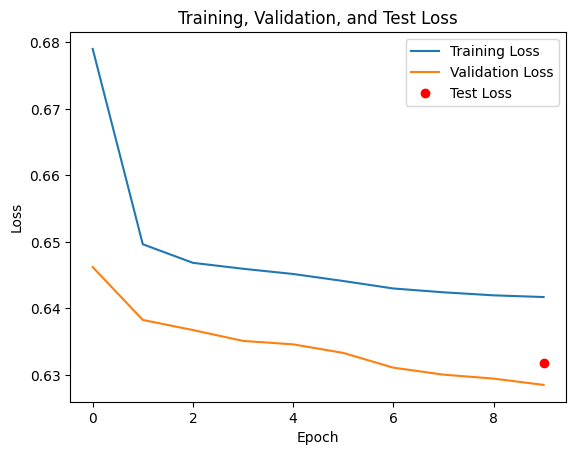

In [44]:
# Plot the training, validation, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(len(history.history['loss']) - 1, test_loss, 'ro', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

#### Predict - Batches

In [45]:
test_data = test_read.map(prep_batch).map(lambda x, _: normalizer(x)).batch(100).prefetch(tf.data.AUTOTUNE)

In [46]:
predictions = autoencoder.predict(test_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


In [47]:
predictions

array([[-0.47625577,  0.10188028,  0.1137526 , ...,  0.03184289,
         0.07397414, -0.26208693],
       [ 0.25925243, -0.44603217,  0.4274537 , ...,  0.16213606,
         0.192825  , -0.28394613],
       [-0.41701323, -0.00727507,  0.1647827 , ...,  0.04646795,
         0.0858095 , -0.2650459 ],
       ...,
       [-0.25970766, -0.18067461,  0.2548567 , ...,  0.07710715,
         0.11267196, -0.27062568],
       [-0.59556407,  0.32170784,  0.01098327, ...,  0.00238954,
         0.05013897, -0.25612786],
       [-0.42687982,  0.01090431,  0.15628384, ...,  0.0440322 ,
         0.08383836, -0.2645531 ]], dtype=float32)

#### Predict - Instances

In [48]:
test_instances = next(iter(test_read.map(prep_batch).batch(3).take(1)))[0] # get first element of tuple for prediction
test_instances

<tf.Tensor: shape=(3, 30), dtype=float64, numpy=
array([[ 4.33300000e+04, -1.51030791e+00,  7.80683602e-01,
         2.08574736e+00,  3.12313283e+00,  5.89556504e-01,
         1.30168094e+00, -1.30099101e+00, -2.34533311e+00,
         1.48722209e-01,  1.06300824e+00, -1.88035726e+00,
         3.10971711e-01,  9.54298638e-01, -1.10646280e+00,
        -7.86015840e-01, -5.55324333e-01,  3.35236557e-01,
         1.85637688e-01,  1.54380629e+00, -6.44864027e-01,
         2.22981820e+00, -4.60620924e-02, -3.41323962e-01,
        -3.70869344e-01, -2.01199298e-01,  4.23963954e-01,
         2.10998182e-01, -5.86163935e-02,  0.00000000e+00],
       [ 1.41955000e+05, -1.58553155e+00,  1.24041103e+00,
        -5.58349101e-01, -8.41657245e-01,  3.97502038e-01,
        -1.53272269e+00,  3.88817678e-01,  5.75896042e-01,
        -2.78369582e-01, -8.56928209e-01, -1.11892547e+00,
         7.37223588e-01,  4.79262560e-01,  7.95002104e-01,
        -3.96344845e-01, -3.62277829e-01,  4.99583980e-02,
      

In [49]:
autoencoder.predict(normalizer(test_instances))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[-0.47625577,  0.10188031,  0.11375259,  0.36196983,  0.02308019,
        -0.1170883 , -0.14762762,  0.00453098,  0.05918864, -0.10916252,
        -0.14334682,  0.03033713,  0.13234511, -0.01367279,  0.04027231,
         0.18594632,  0.0730597 , -0.04581003, -0.02715869,  0.00775086,
        -0.05403591, -0.05755856, -0.05162937, -0.06216056,  0.08418617,
         0.17528105, -0.11270259,  0.03184289,  0.07397413, -0.26208693],
       [ 0.2592525 , -0.44603223,  0.42745373,  0.22593647, -0.32167584,
         0.28658304, -0.26387367,  0.3899756 ,  0.06240054, -0.20570219,
        -0.33909765, -0.15789467,  0.05500156, -0.07290098,  0.05710696,
        -0.13108519,  0.04188603, -0.16366577,  0.06641005, -0.01456203,
        -0.02680407,  0.02435879,  0.22614399, -0.06949002,  0.06222975,
        -0.37314683, -0.05583516,  0.16213608,  0.192825  , -0.28394613],
       [-0.4170132 , -0.0072751 ,  0.16478273,  0.38240007, -0.01985078,
        -0.06809977, -0.15471669,  0.05551817,  0

In [50]:
denormalizer(autoencoder.predict(normalizer(test_instances)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Array([[ 7.22512500e+04,  2.03267962e-01,  1.80700496e-01,
         5.39517283e-01,  2.44477000e-02, -1.50053352e-01,
        -1.94523960e-01,  1.31842084e-02,  6.84100240e-02,
        -1.13901354e-01, -1.40763730e-01,  2.36763172e-02,
         1.36094496e-01, -1.43936230e-02,  4.73453701e-02,
         1.70511499e-01,  6.84321970e-02, -2.14699134e-02,
        -1.94617324e-02,  5.25494711e-03, -4.17732075e-02,
        -4.28560078e-02, -3.76629531e-02, -3.85347232e-02,
         5.05364388e-02,  9.03848559e-02, -5.42074256e-02,
         1.18846186e-02,  2.42445264e-02,  2.43057289e+01],
       [ 1.07195047e+05, -8.53685558e-01,  6.93429232e-01,
         3.41347873e-01, -4.58241403e-01,  3.90979141e-01,
        -3.48214030e-01,  4.58213300e-01,  7.21496195e-02,
        -2.19128117e-01, -3.44976604e-01, -1.65272221e-01,
         6.28745183e-02, -7.32995197e-02,  6.24543317e-02,
        -1.19710699e-01,  4.21078838e-02, -1.10083453e-01,
         5.78879453e-02, -1.28626004e-02, -2.12034099e-

#### Visualize Reconstructions

Original Data Units:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


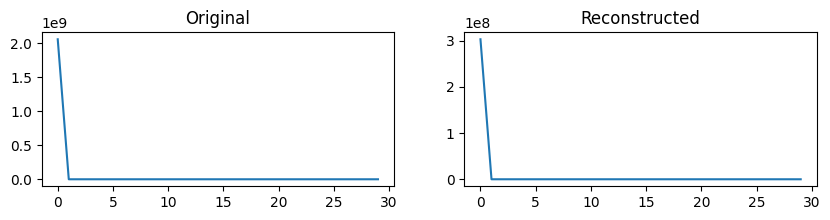

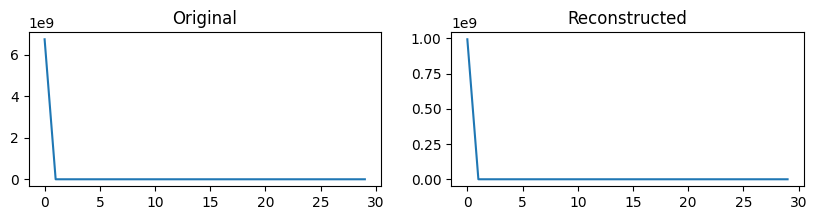

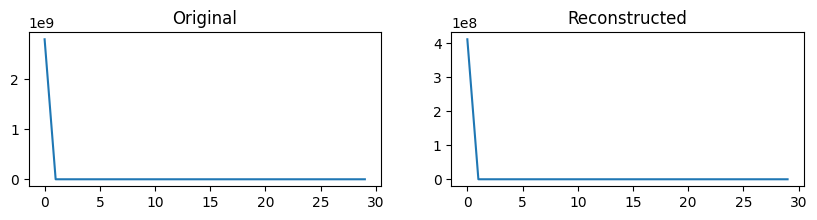

In [51]:
reconstructions = autoencoder.predict(test_instances)
denormalized_inputs = denormalizer(test_instances)
denormalized_reconstructions = denormalizer(reconstructions)

for i in range(test_instances.shape[0]):
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.plot(denormalized_inputs[i])  # Original
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.plot(denormalized_reconstructions[i])  # Reconstructed
    plt.title('Reconstructed')

    plt.show()

Normalized Data:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


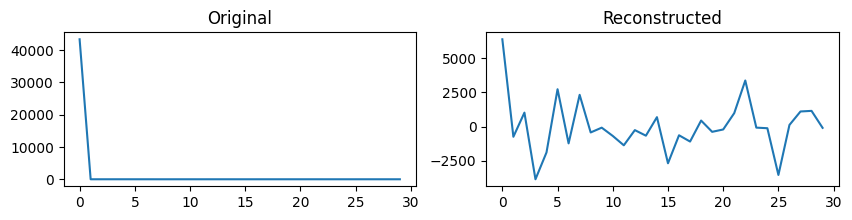

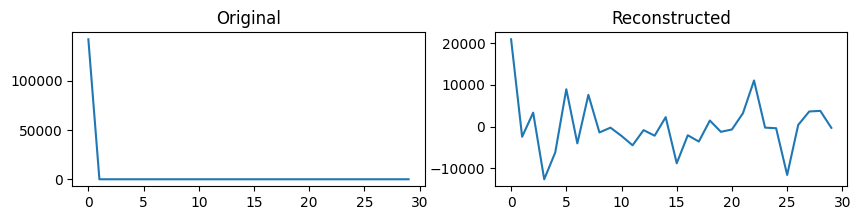

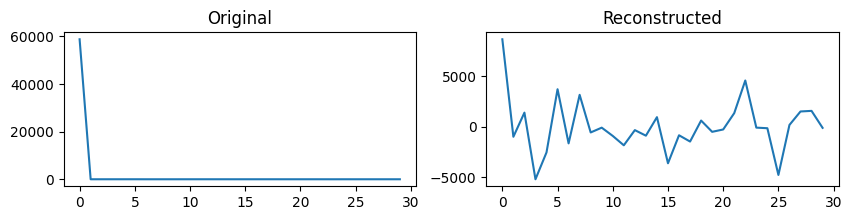

In [52]:
reconstructions = autoencoder.predict(test_instances)

for i in range(test_instances.shape[0]):
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.plot(test_instances[i])  # Original
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.plot(reconstructions[i])  # Reconstructed
    plt.title('Reconstructed')

    plt.show()

#### Continue Training

Rather than starting the training over we can continue it.

**About Continued Training**
- **Continued Training** or **Fine Tuning** is using the same or similar data to continue to train the model to refine the weights.  Usually all layers are left unlocked and are trainable.
- **Transfer Learning** is using a new, more targeted data source to continue to train the model and refine the weights of higher layers while leaving the lower layers frozen. The earlier training might even be referrred to as pre-training when it involved training on a much larger more general data source and the continued training is now on a smaller, related, but more specific data source.
    - lower layers usually learn general features
    - higher layers usually more task-specific

Earlier the learning rate was fixed with `learning_rate = 0.0005`.  Recompile the model with a learning rate scheduler and then continue the training for 10 more epochs.

In [53]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0005,  # Start with the previous LR
    decay_steps = 1000,            # Decay every 1000 steps
    decay_rate = 0.95,              # Decay by 5%
    staircase = True               # Integer decay (optional)
)

In [54]:
# Recompile the model with the new learning rate:
autoencoder.compile(
    optimizer = keras.optimizers.Adam(learning_rate = lr_scheduler),
    loss = custom_loss,
    metrics = [
        keras.metrics.RootMeanSquaredError(name = 'rmse'),
        keras.metrics.MeanSquaredError(name = 'mse'),
        keras.metrics.MeanAbsoluteError(name = 'mae'),
        keras.metrics.MeanSquaredLogarithmicError(name = 'msle')
    ]
)

In [55]:
# Continue training, appending to the history:
continued_history = autoencoder.fit(
    train_dataset,
    epochs = 10,  # Train for 10 *more* epochs
    validation_data = val_dataset
)

Epoch 1/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.6404 - mae: 0.6343 - mse: 0.9569 - msle: 0.1284 - rmse: 0.9781 - val_loss: 0.6287 - val_mae: 0.6227 - val_mse: 0.9357 - val_msle: 0.1265 - val_rmse: 0.9673
Epoch 2/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.6428 - mae: 0.6368 - mse: 0.9773 - msle: 0.1292 - rmse: 0.9886 - val_loss: 0.6282 - val_mae: 0.6223 - val_mse: 0.9359 - val_msle: 0.1259 - val_rmse: 0.9674
Epoch 3/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.6408 - mae: 0.6349 - mse: 0.9749 - msle: 0.1285 - rmse: 0.9873 - val_loss: 0.6272 - val_mae: 0.6213 - val_mse: 0.9336 - val_msle: 0.1255 - val_rmse: 0.9662
Epoch 4/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.6410 - mae: 0.6351 - mse: 0.9651 - msle: 0.1285 - rmse: 0.9824 - val_loss: 0.6277 - val_mae: 0.6218 - val_mse: 0.9347 - val_msle: 0.1257 - val_rmse: 0.9668
Epoch 5/10
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.6414 - mae: 0.6356 - mse: 0.9701 - msle: 0.128

In [56]:
# Combine Histories:
for key in continued_history.history.keys():
    history.history[key] += continued_history.history[key]

In [57]:
test_loss, test_rmse, test_mse, test_mae, test_msle = autoencoder.evaluate(test_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.6360 - mae: 0.6304 - mse: 0.9673 - msle: 0.1264 - rmse: 0.9828


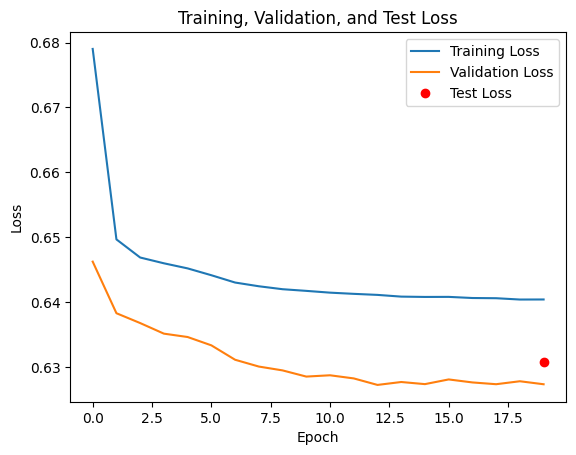

In [58]:
# Plot the training, validation, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(len(history.history['loss']) - 1, test_loss, 'ro', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

## Create An Encoder Model From The Latent Layer

There are times where the only prediction you want from the trained autoencoder is the latent layer.  This layer makes a great encoder for creating embeddings for doing things like vector similarity search to identify similar records!

We don't need to retrain the model, just create a model object from now trained autoencoders `latent` layer.

In [59]:
latent_layer = autoencoder.get_layer('latent')
latent_dim = latent.shape[-1]
encoder_model = keras.Model(inputs = autoencoder.input, outputs = latent_layer.output, name = 'encoder')

### Predict With The Latent Model

Notice that the latent layers predictions are the 4 dimension representation trained in the middle of the autoencoder:

In [60]:
encoder_model.predict(normalizer(test_instances))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[0.1785011 , 0.4892008 , 0.        , 0.43396142],
       [0.55523515, 1.5147265 , 0.        , 1.3510681 ],
       [0.21880712, 0.5989169 , 0.        , 0.5320784 ]], dtype=float32)

---
## Enchance Autoencoder

Create new model objects that are built around the trained autoencoder.  With Keras models can be layers in new models.  Here a new model combines the preprocessing layers, normalizer and denormalizer, with the autoencoder into a new model object we will call a stacked model.  These make serving easier!

### Stacked Model - Combined Preprocessing, Model, and Postprocessing

Simply stack the normalizer + autoencoder + denormalizer in a new model object:

In [61]:
type(normalizer), type(autoencoder), type(denormalizer)

(keras.src.layers.preprocessing.normalization.Normalization,
 keras.src.models.functional.Functional,
 keras.src.layers.preprocessing.normalization.Normalization)

In [62]:
# Create a new sequential model
stacked_model = keras.Sequential([
    normalizer,
    autoencoder,
    denormalizer
], name='stacked_autoencoder')

#### Predict

In [63]:
test_instances = test_read.map(prep_batch).batch(100).prefetch(tf.data.AUTOTUNE)

In [64]:
predictions = stacked_model.predict(test_instances)

285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [65]:
predictions[0:3]

array([[ 7.31116875e+04,  1.95274860e-01,  1.98405266e-01,
         5.48646986e-01,  1.03527317e-02, -1.37672216e-01,
        -2.04011068e-01,  3.97498310e-02,  6.71286136e-02,
        -1.14381485e-01, -1.44841924e-01,  1.29170734e-02,
         1.36223808e-01, -3.79151618e-03,  3.54224630e-02,
         1.57269984e-01,  6.89257383e-02, -2.59750988e-02,
        -1.88401360e-02,  3.45026143e-03, -3.51894833e-02,
        -4.49660085e-02, -3.99731547e-02, -3.55563238e-02,
         4.94298451e-02,  8.59789401e-02, -5.14667556e-02,
         1.70545857e-02,  2.65499149e-02,  2.30726929e+01],
       [ 1.07418891e+05, -7.86004305e-01,  6.60529375e-01,
         3.31001550e-01, -4.39224809e-01,  3.77953559e-01,
        -3.55927378e-01,  4.60388958e-01,  6.14287369e-02,
        -2.02556923e-01, -3.18596035e-01, -1.67331085e-01,
         7.49440715e-02, -5.12692221e-02,  4.76767793e-02,
        -1.24875531e-01,  4.81583662e-02, -1.03736721e-01,
         4.33987081e-02, -2.12585367e-02, -1.39731243e-

#### Review The Model

In [66]:
stacked_model.summary()

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (100, 30)              │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autoencoder (Functional)        │ (100, 30)              │         1,362 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denormalize (Normalization)     │ (100, 30)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

In [67]:
stacked_model.summary(expand_nested=True)

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (100, 30)              │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ autoencoder (Functional)        │ (100, 30)              │         1,362 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ autoencoder_input          │ (None, 30)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dense1 (Dense)         │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dropout1 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dense2 (Dense)         │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ enc_dropout2 (Dropout)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ latent (Dense)             │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dense1 (Dense)         │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dropout1 (Dropout)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dense2 (Dense)         │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dec_dropout2 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reconstructed (Dense)      │ (None, 30)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denormalize (Normalization)     │ (100, 30)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

### Model Built From Models - Combining Models and Customizing Outputs

More than stacking, also output reconstructed data in both the normalized and denormalized (original units) form:

In [68]:
input_layer = keras.Input(shape=(autoencoder.input.shape[1],), name="serving_input")
normalized_input = normalizer(input_layer)
latent_output = encoder_model(normalized_input)
reconstructed_raw = autoencoder(normalized_input)
multiple_outputs = {
    'normalized': reconstructed_raw,  # Output directly from autoencoder
    'denormalized': denormalizer(reconstructed_raw),  # Apply denormalization
    'encoded': latent_output
}
stacked_autoencoder = keras.Model(inputs = input_layer, outputs = multiple_outputs, name="stacked_autoencoder")

#### Review The Model

In [69]:
stacked_autoencoder.summary()

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ serving_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 30)        │         61 │ serving_input[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ autoencoder         │ (None, 30)        │      1,362 │ normalization[1]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ denormalize         │ (None, 30)        │          0 │ autoencoder[1][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 4)         │        668 │ normalization[1]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

In [70]:
stacked_autoencoder.summary(expand_nested=True)

Model: "stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ serving_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 30)        │         61 │ serving_input[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ autoencoder         │ (None, 30)        │      1,362 │ normalization[1]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 30)        │          0 │ -                 │
│ autoencoder_input   │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ enc_dense1     │ (None, 16)        │        496 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ enc_dropout1   │ (None, 16)        │          0 │ -                 │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ enc_dense2     │ (None, 8)         │        136 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ enc_dropout2   │ (None, 8)         │          0 │ -                 │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ latent (Dense) │ (None, 4)         │         36 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dec_dense1     │ (None, 8)         │         40 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dec_dropout1   │ (None, 8)         │          0 │ -                 │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dec_dense2     │ (None, 16)        │        144 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dec_dropout2   │ (None, 16)        │          0 │ -                 │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ reconstructed  │ (None, 30)        │        510 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ denormalize         │ (None, 30)        │          0 │ autoencoder[1][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 4)         │        668 │ normalization[1]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 30)        │          0 │ -               

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

#### Predict

In [71]:
test_instances = test_read.map(prep_batch).batch(100).prefetch(tf.data.AUTOTUNE)

In [72]:
predictions = stacked_autoencoder.predict(test_instances)

285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [73]:
predictions['denormalized'][0:3]

array([[ 7.31116875e+04,  1.95274860e-01,  1.98405266e-01,
         5.48646986e-01,  1.03527317e-02, -1.37672216e-01,
        -2.04011068e-01,  3.97498310e-02,  6.71286136e-02,
        -1.14381485e-01, -1.44841924e-01,  1.29170734e-02,
         1.36223808e-01, -3.79151618e-03,  3.54224630e-02,
         1.57269984e-01,  6.89257383e-02, -2.59750988e-02,
        -1.88401360e-02,  3.45026143e-03, -3.51894833e-02,
        -4.49660085e-02, -3.99731547e-02, -3.55563238e-02,
         4.94298451e-02,  8.59789401e-02, -5.14667556e-02,
         1.70545857e-02,  2.65499149e-02,  2.30726929e+01],
       [ 1.07418891e+05, -7.86004305e-01,  6.60529375e-01,
         3.31001550e-01, -4.39224809e-01,  3.77953559e-01,
        -3.55927378e-01,  4.60388958e-01,  6.14287369e-02,
        -2.02556923e-01, -3.18596035e-01, -1.67331085e-01,
         7.49440715e-02, -5.12692221e-02,  4.76767793e-02,
        -1.24875531e-01,  4.81583662e-02, -1.03736721e-01,
         4.33987081e-02, -2.12585367e-02, -1.39731243e-

In [74]:
predictions['normalized'][0:3]

array([[-0.4581449 ,  0.09773678,  0.12458484,  0.3682369 ,  0.01301299,
        -0.10785058, -0.15480335,  0.02753976,  0.05808806, -0.10960302,
        -0.14725602,  0.0196187 ,  0.1324817 , -0.00301268,  0.0269876 ,
         0.17148161,  0.07364415, -0.05180191, -0.02640675,  0.00552828,
        -0.04531988, -0.06050033, -0.05482286, -0.05736965,  0.08235714,
         0.16682586, -0.1070304 ,  0.04496535,  0.08098096, -0.26716912],
       [ 0.26396406, -0.41094705,  0.4073247 ,  0.21883427, -0.30809343,
         0.27686447, -0.2697078 ,  0.39185998,  0.05319249, -0.19049904,
        -0.31381023, -0.15994574,  0.06775084, -0.05075015,  0.04064157,
        -0.13672712,  0.04905111, -0.15522464,  0.04888264, -0.02490216,
        -0.01723208,  0.01102684,  0.20995659, -0.04579758,  0.05857809,
        -0.35765472, -0.0433526 ,  0.17300427,  0.18871398, -0.28667575],
       [-0.40907967,  0.00690913,  0.16406076,  0.3835163 , -0.02073202,
        -0.06870484, -0.16057144,  0.06805073,  0

In [75]:
predictions['encoded'][0:3]

array([[0.17850108, 0.4892008 , 0.        , 0.43396136],
       [0.55523515, 1.5147265 , 0.        , 1.3510681 ],
       [0.21880712, 0.5989169 , 0.        , 0.5320784 ]], dtype=float32)

### Adding Named Inputs

How can we prevent feature order drift?  How about modifying the input to receive a dictionary of key:value pairs that map to the correct order inside the model!

Named inputs, a dictionary of features
- input dictionary, concatenate features, pass to the stacked model

Why?
- user-friendly!
- prevent training serving skew from feature order drift causing serving error


Using an ordered dictionary for the input layers ensures the inputs order as they pass to the concatenation layers is consistent.  The inputs to the model can actually be out of order but this ordering of the input layer will force the consistency needed.

#### Input Layer

In [76]:
input_dict = OrderedDict()
for key in var_numeric:
    input_dict[key] = keras.layers.Input(shape=(1,), name=key)

In [77]:
concatenated_inputs = keras.layers.Concatenate(axis = -1)(list(input_dict.values()))

#### Model

In [78]:
ordered_model = keras.Model(inputs = input_dict, outputs = stacked_autoencoder(concatenated_inputs))

#### Data Mapping

In [79]:
def prep_batch_ordered(source):
    for k in var_omit + var_target:
        source.pop(k, None)
        
    #Check the keys
    if set(source.keys()) != set(var_numeric):
        raise ValueError("Input data keys do not match expected feature names.")

    return OrderedDict((key, source[key]) for key in var_numeric)    

In [80]:
test_instances = test_read.map(prep_batch_ordered).batch(100).prefetch(tf.data.AUTOTUNE)

#### Predict

In [81]:
predictions = ordered_model.predict(test_instances)

285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [82]:
predictions['normalized'][0:3]

array([[-0.4581449 ,  0.09773678,  0.12458484,  0.3682369 ,  0.01301299,
        -0.10785058, -0.15480335,  0.02753976,  0.05808806, -0.10960302,
        -0.14725602,  0.0196187 ,  0.1324817 , -0.00301268,  0.0269876 ,
         0.17148161,  0.07364415, -0.05180191, -0.02640675,  0.00552828,
        -0.04531988, -0.06050033, -0.05482286, -0.05736965,  0.08235714,
         0.16682586, -0.1070304 ,  0.04496535,  0.08098096, -0.26716912],
       [ 0.26396406, -0.41094705,  0.4073247 ,  0.21883427, -0.30809343,
         0.27686447, -0.2697078 ,  0.39185998,  0.05319249, -0.19049904,
        -0.31381023, -0.15994574,  0.06775084, -0.05075015,  0.04064157,
        -0.13672712,  0.04905111, -0.15522464,  0.04888264, -0.02490216,
        -0.01723208,  0.01102684,  0.20995659, -0.04579758,  0.05857809,
        -0.35765472, -0.0433526 ,  0.17300427,  0.18871398, -0.28667575],
       [-0.40907967,  0.00690913,  0.16406076,  0.3835163 , -0.02073202,
        -0.06870484, -0.16057144,  0.06805073,  0

#### Review The Model

In [83]:
ordered_model.summary(expand_nested = True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Time (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V1 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V2 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V3 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V7 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V8 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V9 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V10 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V11 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V13 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V14 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V15 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V16 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V17 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V18 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V19 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V20 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V21 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V22 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V23 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V24 (InputLayer)    │ (None, 1)         │          0 │ -               

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

### Detailed Post-Processing

Derive useful information from the reconstructed data, both normalized and denormalized.

In [84]:
def post_process_predictions(inputs, predictions):
    inputs = jnp.array(inputs)
    normalized_inputs = normalizer(inputs)
    normalized_reconstruction = predictions['normalized']
    denormalized_reconstruction = predictions['denormalized']

    # Per-instance, aggregated metrics.  Keep axis=-1, then reshape.
    norm_mae = jnp.mean(jnp.abs(normalized_reconstruction - normalized_inputs), axis=-1)
    norm_rmse = jnp.sqrt(jnp.mean(jnp.square(normalized_reconstruction - normalized_inputs), axis=-1))
    norm_mse = jnp.mean(jnp.square(normalized_reconstruction - normalized_inputs), axis=-1)
    norm_msle = jnp.mean(jnp.square(jnp.log1p(jnp.maximum(0.0, normalized_reconstruction)) - jnp.log1p(jnp.maximum(0.0, normalized_inputs))), axis=-1)

    denorm_mae = jnp.mean(jnp.abs(denormalized_reconstruction - inputs), axis=-1)
    denorm_rmse = jnp.sqrt(jnp.mean(jnp.square(denormalized_reconstruction - inputs), axis=-1))
    denorm_mse = jnp.mean(jnp.square(denormalized_reconstruction - inputs), axis=-1)
    denorm_msle = jnp.mean(jnp.square(jnp.log1p(jnp.maximum(0.0, denormalized_reconstruction)) - jnp.log1p(jnp.maximum(0.0, inputs))), axis=-1)

    normalized_errors = normalized_inputs - normalized_reconstruction
    denormalized_errors = inputs - denormalized_reconstruction

    results = []
    num_instances = inputs.shape[0]
    for i in range(num_instances):
        instance_data = {
            'normalized': {
                'reconstruction': np.array(normalized_reconstruction[i]),
                'reconstruction_errors': np.array(normalized_errors[i]),
                'metrics': {  # Scalar metrics per instance
                    'MAE': np.array(norm_mae[i]).reshape(()),  # Reshape to scalar
                    'RMSE': np.array(norm_rmse[i]).reshape(()),
                    'MSE': np.array(norm_mse[i]).reshape(()),
                    'MSLE': np.array(norm_msle[i]).reshape(())
                }
            },
            'denormalized': {
                'reconstruction': np.array(denormalized_reconstruction[i]),
                'reconstruction_errors': np.array(denormalized_errors[i]),
                'metrics': {  # Scalar metrics per instance
                    'MAE': np.array(denorm_mae[i]).reshape(()),
                    'RMSE': np.array(denorm_rmse[i]).reshape(()),
                    'MSE': np.array(denorm_mse[i]).reshape(()),
                    'MSLE': np.array(denorm_msle[i]).reshape(())
                }
            },
            'encoded': np.array(predictions['encoded'][i])
        }
        results.append(instance_data)
    return results


In [85]:
def prep_serving_batch(source):
    for k in var_omit + var_target:
        source.pop(k, None)
    numeric_values = tf.stack([source[col] for col in var_numeric], axis=-1)
    return numeric_values

In [86]:
test_instances = test_read.map(prep_serving_batch).batch(100).prefetch(tf.data.AUTOTUNE)

# Get raw predictions from stacked_autoencoder
raw_predictions = stacked_autoencoder.predict(test_instances)

285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [87]:
raw_predictions

{'denormalized': array([[ 7.3111688e+04,  1.9527486e-01,  1.9840527e-01, ...,
          1.7054586e-02,  2.6549915e-02,  2.3072693e+01],
        [ 1.0741889e+05, -7.8600430e-01,  6.6052938e-01, ...,
          6.7499153e-02,  6.1996296e-02,  1.8340019e+01],
        [ 7.5442766e+04,  2.0063320e-02,  2.6292667e-01, ...,
          2.1662012e-02,  2.9460700e-02,  2.2505590e+01],
        ...,
        [ 8.3182023e+04, -3.4287983e-01,  4.1159335e-01, ...,
          3.4234658e-02,  3.7895415e-02,  2.1135464e+01],
        [ 6.6167938e+04,  7.1719116e-01,  6.2102992e-03, ...,
          3.3300745e-03,  1.7879328e-02,  2.4761965e+01],
        [ 7.4317469e+04,  1.0464430e-01,  2.3177983e-01, ...,
          1.9437840e-02,  2.8055556e-02,  2.2779348e+01]], dtype=float32),
 'encoded': array([[0.17850108, 0.4892008 , 0.        , 0.43396136],
        [0.55523515, 1.5147265 , 0.        , 1.3510681 ],
        [0.21880712, 0.5989169 , 0.        , 0.5320784 ],
        ...,
        [0.31674692, 0.86552584, 0. 

In [88]:
processed_predictions = post_process_predictions(tf.concat(list(test_instances), axis=0), raw_predictions)

In [89]:
processed_predictions[0]

{'normalized': {'reconstruction': array([-0.4581449 ,  0.09773678,  0.12458484,  0.3682369 ,  0.01301299,
         -0.10785058, -0.15480335,  0.02753976,  0.05808806, -0.10960302,
         -0.14725602,  0.0196187 ,  0.1324817 , -0.00301268,  0.0269876 ,
          0.17148161,  0.07364415, -0.05180191, -0.02640675,  0.00552828,
         -0.04531988, -0.06050033, -0.05482286, -0.05736965,  0.08235714,
          0.16682586, -0.1070304 ,  0.04496535,  0.08098096, -0.26716912],
        dtype=float32),
  'reconstruction_errors': array([-0.62685454, -0.88415444,  0.35625345,  1.0551418 ,  2.2232733 ,
          0.5425948 ,  1.1388553 , -1.1612306 , -2.0720363 ,  0.24138293,
          1.1578001 , -1.8860928 ,  0.18458924,  0.96333206, -1.2723076 ,
         -1.030422  , -0.7392466 ,  0.48041046,  0.24735373,  1.8970453 ,
         -0.80713266,  3.1715102 , -0.00841702, -0.4918419 , -0.6946919 ,
         -0.55111015,  0.98396975,  0.4922696 , -0.25884798, -0.09509858],
        dtype=float32),
  'me

### Custom Layers For Post-Processing Inside The Model

In [90]:
@keras.saving.register_keras_serializable()
class PostProcessingLayer(keras.layers.Layer):
    def __init__(self, autoencoder, normalizer, denormalizer, encoder_model, **kwargs):
        super().__init__(**kwargs)
        self.autoencoder = autoencoder
        self.normalizer = normalizer
        self.denormalizer = denormalizer
        self.encoder_model = encoder_model

        # Define output signature (Flattened)
        self.output_signature = {
            'normalized_reconstruction': tf.TensorSpec(shape=(None, len(var_numeric)), dtype=tf.float32),
            'normalized_reconstruction_errors': tf.TensorSpec(shape=(None, len(var_numeric)), dtype=tf.float32),
            'normalized_MAE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'normalized_RMSE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'normalized_MSE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'normalized_MSLE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'denormalized_reconstruction': tf.TensorSpec(shape=(None, len(var_numeric)), dtype=tf.float32),
            'denormalized_reconstruction_errors': tf.TensorSpec(shape=(None, len(var_numeric)), dtype=tf.float32),
            'denormalized_MAE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'denormalized_RMSE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'denormalized_MSE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'denormalized_MSLE': tf.TensorSpec(shape=(None,), dtype=tf.float32),
            'encoded': tf.TensorSpec(shape=(None, latent_dim), dtype=tf.float32)
        }
    def call(self, inputs):
        normalized_inputs = self.normalizer(inputs)
        normalized_reconstruction = self.autoencoder(normalized_inputs)
        denormalized_reconstruction = self.denormalizer(normalized_reconstruction)
        latent_output = self.encoder_model(normalized_inputs)

        norm_mae = jnp.mean(jnp.abs(normalized_reconstruction - normalized_inputs), axis=-1)
        norm_rmse = jnp.sqrt(jnp.mean(jnp.square(normalized_reconstruction - normalized_inputs), axis=-1))
        norm_mse = jnp.mean(jnp.square(normalized_reconstruction - normalized_inputs), axis=-1)
        norm_msle = jnp.mean(jnp.square(jnp.log1p(jnp.maximum(0.0, normalized_reconstruction)) - jnp.log1p(jnp.maximum(0.0, normalized_inputs))), axis=-1)

        denorm_mae = jnp.mean(jnp.abs(denormalized_reconstruction - inputs), axis=-1)
        denorm_rmse = jnp.sqrt(jnp.mean(jnp.square(denormalized_reconstruction - inputs), axis=-1))
        denorm_mse = jnp.mean(jnp.square(denormalized_reconstruction - inputs), axis=-1)
        denorm_msle = jnp.mean(jnp.square(jnp.log1p(jnp.maximum(0.0, denormalized_reconstruction)) - jnp.log1p(jnp.maximum(0.0, inputs))), axis=-1)

        normalized_errors = normalized_inputs - normalized_reconstruction
        denormalized_errors = inputs - denormalized_reconstruction

        # Flattened output dictionary
        return {
            'normalized_reconstruction': normalized_reconstruction,
            'normalized_reconstruction_errors': normalized_errors,
            'normalized_MAE': norm_mae,
            'normalized_RMSE': norm_rmse,
            'normalized_MSE': norm_mse,
            'normalized_MSLE': norm_msle,
            'denormalized_reconstruction': denormalized_reconstruction,
            'denormalized_reconstruction_errors': denormalized_errors,
            'denormalized_MAE': denorm_mae,
            'denormalized_RMSE': denorm_rmse,
            'denormalized_MSE': denorm_mse,
            'denormalized_MSLE': denorm_msle,
            'encoded': latent_output
        }


    def get_config(self):
        config = super().get_config()
        config.update({
            'autoencoder': keras.saving.serialize_keras_object(self.autoencoder),
            'normalizer': keras.saving.serialize_keras_object(self.normalizer),
            'denormalizer': keras.saving.serialize_keras_object(self.denormalizer),
            'encoder_model': keras.saving.serialize_keras_object(self.encoder_model),
        })
        return config

    @classmethod
    def from_config(cls, config):
        autoencoder = keras.saving.deserialize_keras_object(config['autoencoder'])
        normalizer = keras.saving.deserialize_keras_object(config['normalizer'])
        denormalizer = keras.saving.deserialize_keras_object(config['denormalizer'])
        encoder_model = keras.saving.deserialize_keras_object(config['encoder_model'])
        del config["autoencoder"]
        del config["encoder_model"]
        del config["normalizer"]
        del config["denormalizer"]
        return cls(autoencoder=autoencoder, normalizer=normalizer, denormalizer=denormalizer, encoder_model=encoder_model, **config)


In [91]:
input_layer = keras.Input(shape=(len(var_numeric),), name="input_layer")  # Single input
outputs = PostProcessingLayer(autoencoder, normalizer, denormalizer, encoder_model)(input_layer) # Pass single tensor
final_model = keras.Model(inputs=input_layer, outputs=outputs, name='final_model')  # Single input
final_model.summary(expand_nested=True)

Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ post_processing_layer           │ [(None), (None),       │         1,423 │
│ (PostProcessingLayer)           │ (None), (None), (None, │               │
│                                 │ 30), (None, 30),       │               │
│                                 │ (None, 4), (None),     │               │
│                                 │ (None), (None),        │               │
│                                 │ (None), (None, 30),    │               │
│                                 │ (None, 30)]            │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423 (5.56 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 61 (244.00 B)

In [92]:
def prep_serving_batch(source):
    for k in var_omit + var_target:
        source.pop(k, None)
    numeric_values = tf.stack([source[col] for col in var_numeric], axis=-1)
    #return numeric_values
    return tf.cast(numeric_values, tf.float32)

test_instances = test_read.map(prep_serving_batch).batch(100).prefetch(tf.data.AUTOTUNE)
predictions = final_model.predict(test_instances)

285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [93]:
predictions

{'denormalized_MAE': array([ 994.3885 , 1152.1715 ,  556.51013, ..., 1549.9999 , 3024.6917 ,
        2076.5974 ], dtype=float32),
 'denormalized_MSE': array([2.9564982e+07, 3.9758112e+07, 9.2183250e+06, ..., 7.1512720e+07,
        2.7316090e+08, 1.2670152e+08], dtype=float32),
 'denormalized_MSLE': array([0.5835977 , 0.33087322, 0.69379145, ..., 0.3025487 , 0.25527957,
        0.5450897 ], dtype=float32),
 'denormalized_RMSE': array([ 5437.369 ,  6305.4033,  3036.1694, ...,  8456.52  , 16527.58  ,
        11256.177 ], dtype=float32),
 'denormalized_reconstruction': array([[ 7.3111688e+04,  1.9527486e-01,  1.9840527e-01, ...,
          1.7054586e-02,  2.6549915e-02,  2.3072693e+01],
        [ 1.0741889e+05, -7.8600430e-01,  6.6052938e-01, ...,
          6.7499153e-02,  6.1996296e-02,  1.8340019e+01],
        [ 7.5442766e+04,  2.0063320e-02,  2.6292667e-01, ...,
          2.1662012e-02,  2.9460700e-02,  2.2505590e+01],
        ...,
        [ 8.3182023e+04, -3.4287983e-01,  4.1159335e-01,

In [101]:
def convert_to_list_of_dicts(predictions):
    results_list = []
    num_instances = predictions['normalized_reconstruction'].shape[0]  # Get batch size

    for i in range(num_instances):
        instance_data = {}
        for key, value in predictions.items():
             # Check if the value is a NumPy array before slicing
            if isinstance(value, np.ndarray):
                 instance_data[key] = value[i]  # Get the i-th instance
            #if it is a tensor
            elif isinstance(value, tf.Tensor):
                instance_data[key] = value[i].numpy()
            else:
                instance_data[key] = value #keep as is if not array/tensor

        results_list.append(instance_data)
    return results_list

In [102]:
processed_predictions = convert_to_list_of_dicts(predictions)

In [103]:
print(len(processed_predictions))
print(processed_predictions[0])

28432
{'denormalized_MAE': 994.3885, 'denormalized_MSE': 29564982.0, 'denormalized_MSLE': 0.5835977, 'denormalized_RMSE': 5437.369, 'denormalized_reconstruction': array([ 7.31116875e+04,  1.95274860e-01,  1.98405266e-01,  5.48646986e-01,
        1.03527317e-02, -1.37672216e-01, -2.04011068e-01,  3.97498310e-02,
        6.71286136e-02, -1.14381485e-01, -1.44841924e-01,  1.29170734e-02,
        1.36223808e-01, -3.79151618e-03,  3.54224630e-02,  1.57269984e-01,
        6.89257383e-02, -2.59750988e-02, -1.88401360e-02,  3.45026143e-03,
       -3.51894833e-02, -4.49660085e-02, -3.99731547e-02, -3.55563238e-02,
        4.94298451e-02,  8.59789401e-02, -5.14667556e-02,  1.70545857e-02,
        2.65499149e-02,  2.30726929e+01], dtype=float32), 'denormalized_reconstruction_errors': array([-2.9781688e+04, -1.7055827e+00,  5.8227831e-01,  1.5371003e+00,
        3.1127801e+00,  7.2722876e-01,  1.5056920e+00, -1.3407409e+00,
       -2.4124618e+00,  2.6310369e-01,  1.2078501e+00, -1.8932743e+00,
   

In [104]:
single_instance = next(iter(test_read.map(prep_serving_batch).take(1).batch(1)))
single_instance

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[ 4.3330000e+04, -1.5103079e+00,  7.8068358e-01,  2.0857472e+00,
         3.1231329e+00,  5.8955652e-01,  1.3016809e+00, -1.3009911e+00,
        -2.3453331e+00,  1.4872222e-01,  1.0630082e+00, -1.8803573e+00,
         3.1097171e-01,  9.5429862e-01, -1.1064628e+00, -7.8601587e-01,
        -5.5532432e-01,  3.3523655e-01,  1.8563768e-01,  1.5438063e+00,
        -6.4486402e-01,  2.2298181e+00, -4.6062093e-02, -3.4132397e-01,
        -3.7086934e-01, -2.0119929e-01,  4.2396396e-01,  2.1099818e-01,
        -5.8616392e-02,  0.0000000e+00]], dtype=float32)>

In [105]:
final_model.predict(single_instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


{'denormalized_MAE': array([994.38873], dtype=float32),
 'denormalized_MSE': array([29564998.], dtype=float32),
 'denormalized_MSLE': array([0.5835977], dtype=float32),
 'denormalized_RMSE': array([5437.3706], dtype=float32),
 'denormalized_reconstruction': array([[ 7.31116953e+04,  1.95274845e-01,  1.98405296e-01,
          5.48647046e-01,  1.03527252e-02, -1.37672231e-01,
         -2.04011038e-01,  3.97498570e-02,  6.71286210e-02,
         -1.14381485e-01, -1.44841939e-01,  1.29170828e-02,
          1.36223793e-01, -3.79151572e-03,  3.54224592e-02,
          1.57269984e-01,  6.89257383e-02, -2.59750988e-02,
         -1.88401360e-02,  3.45026143e-03, -3.51894796e-02,
         -4.49660048e-02, -3.99731547e-02, -3.55563238e-02,
          4.94298488e-02,  8.59789401e-02, -5.14667481e-02,
          1.70545857e-02,  2.65499130e-02,  2.30726929e+01]], dtype=float32),
 'denormalized_reconstruction_errors': array([[-2.9781695e+04, -1.7055827e+00,  5.8227825e-01,  1.5371002e+00,
          3.11

## Model Saving And Serving

This section shows to to save, load, and serve with the Keras format and with TensorFlow SavedModel format.  The approach to this is different for each.  For Keras the individual model components are saved, reloaded, and then the final model is reconstructed in this example.  For TensorFlow SavedModel the completed `final_model` is saved and loaded completely.

Data for serving examples:

In [106]:
test_instances = test_read.map(prep_serving_batch).batch(100).prefetch(tf.data.AUTOTUNE)
single_instance_ds = test_read.map(prep_serving_batch).take(1).batch(1)  # Single instance
single_instance_tensor = next(iter(single_instance_ds)) #for TF serving

### Keras Format

https://keras.io/api/models/model_saving_apis/model_saving_and_loading/

In [107]:
KERAS_DIR = os.path.join(DIR, "keras")
os.makedirs(KERAS_DIR, exist_ok=True)

#### Save Models

Save each compolent model: autoencoder, encoder_model, normalizer, and denormalizer.

In [108]:
autoencoder.save(os.path.join(KERAS_DIR, 'autoencoder.keras'))
encoder_model.save(os.path.join(KERAS_DIR, 'encoder_model.keras'))

In [109]:
norm_input = keras.Input(shape=(len(var_numeric),))
norm_model = keras.Model(inputs=norm_input, outputs=normalizer(norm_input))
norm_model.compile()  # Compile is necessary before saving
norm_model.save(os.path.join(KERAS_DIR, "normalizer.keras"))

denorm_input = keras.Input(shape=(len(var_numeric),))
denorm_model = keras.Model(inputs=denorm_input, outputs=denormalizer(denorm_input))
denorm_model.compile() # Compile is necessary before saving
denorm_model.save(os.path.join(KERAS_DIR, "denormalizer.keras"))

#### Load Models

Load each component model.

In [110]:
loaded_keras_autoencoder = keras.models.load_model(os.path.join(KERAS_DIR, "autoencoder.keras"))
loaded_keras_encoder_model = keras.models.load_model(os.path.join(KERAS_DIR, "encoder_model.keras"))
loaded_keras_normalizer = keras.models.load_model(os.path.join(KERAS_DIR, "normalizer.keras"))
loaded_keras_denormalizer = keras.models.load_model(os.path.join(KERAS_DIR, "denormalizer.keras"))

#### Prepare Serving Model

In [111]:
input_layer_keras = keras.Input(shape=(len(var_numeric),), name="input_layer_keras")
# Use the LOADED autoencoder, encoder, normalizer and denormalizer:
loaded_keras_outputs = PostProcessingLayer(loaded_keras_autoencoder, loaded_keras_normalizer, loaded_keras_denormalizer, loaded_keras_encoder_model)(input_layer_keras)
loaded_keras_final_model = keras.Model(inputs=input_layer_keras, outputs=loaded_keras_outputs, name='final_model_keras')
loaded_keras_final_model.summary(expand_nested=True)  # Good practice to check

Model: "final_model_keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_keras (InputLayer)  │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ post_processing_layer_1         │ [(None), (None),       │         2,091 │
│ (PostProcessingLayer)           │ (None), (None), (None, │               │
│                                 │ 30), (None, 30),       │               │
│                                 │ (None, 4), (None),     │               │
│                                 │ (None), (None),        │               │
│                                 │ (None), (None, 30),    │               │
│                                 │ (None, 30)]            │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,091 (8.17 KB)

 Trainable params: 2,030 (7.93 KB)

 Non-trainable params: 61 (244.00 B)

#### Predict With Serving Model

In [112]:
loaded_keras_final_model.predict(single_instance_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


{'denormalized_MAE': array([994.38873], dtype=float32),
 'denormalized_MSE': array([29564998.], dtype=float32),
 'denormalized_MSLE': array([0.5835977], dtype=float32),
 'denormalized_RMSE': array([5437.3706], dtype=float32),
 'denormalized_reconstruction': array([[ 7.31116953e+04,  1.95274845e-01,  1.98405296e-01,
          5.48647046e-01,  1.03527252e-02, -1.37672231e-01,
         -2.04011038e-01,  3.97498570e-02,  6.71286210e-02,
         -1.14381485e-01, -1.44841939e-01,  1.29170828e-02,
          1.36223793e-01, -3.79151572e-03,  3.54224592e-02,
          1.57269984e-01,  6.89257383e-02, -2.59750988e-02,
         -1.88401360e-02,  3.45026143e-03, -3.51894796e-02,
         -4.49660048e-02, -3.99731547e-02, -3.55563238e-02,
          4.94298488e-02,  8.59789401e-02, -5.14667481e-02,
          1.70545857e-02,  2.65499130e-02,  2.30726929e+01]], dtype=float32),
 'denormalized_reconstruction_errors': array([[-2.9781695e+04, -1.7055827e+00,  5.8227825e-01,  1.5371002e+00,
          3.11

### TensorFlow SavedModel Format

https://keras.io/api/models/model_saving_apis/export/#export-method

In [113]:
TF_DIR = os.path.join(DIR, "tensorflow")
os.makedirs(TF_DIR, exist_ok=True)

#### Save Model

Save the complete `final_model`.  Similarly the component models can be saved and loaded if needed for the serving use case.

In [114]:
#autoencoder.export(os.path.join(TF_DIR, 'autoencoder'), format = 'tf_saved_model', verbose = False)
#encoder_model.export(os.path.join(TF_DIR, 'encoder_model'), format = 'tf_saved_model', verbose = False)
final_model.export(os.path.join(TF_DIR, 'final_model'), format = 'tf_saved_model', verbose = False)

INFO:tensorflow:Assets written to: files/overview/tensorflow/final_model/assets


INFO:tensorflow:Assets written to: files/overview/tensorflow/final_model/assets


Saved artifact at 'files/overview/tensorflow/final_model'. The following endpoints are available:

* Endpoint 'serve'


#### Load Model

The model is loaded with TensorFlow rather than Keras:

In [115]:
loaded_tf_final_model = tf.saved_model.load(os.path.join(TF_DIR, "final_model"))

#### Prepare Serving Model

In [116]:
infer = loaded_tf_final_model.signatures["serve"]

#### Predictions 

In [117]:
predictions_tf = infer(single_instance_tensor)

I0000 00:00:1739050937.308111 1465905 service.cc:148] XLA service 0x7f6a48022ed0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739050937.308337 1465905 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739050937.569604 1465905 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [118]:
print("\nTensorFlow SavedModel Prediction:")
for key, value in predictions_tf.items():
    print(f"{key}: {value.numpy()}")


TensorFlow SavedModel Prediction:
normalized_reconstruction: [[-0.45814484  0.09773677  0.12458485  0.36823693  0.01301299 -0.10785059
  -0.15480334  0.02753978  0.05808806 -0.10960302 -0.14725603  0.01961871
   0.13248168 -0.00301268  0.0269876   0.17148162  0.07364415 -0.05180191
  -0.02640675  0.00552828 -0.04531988 -0.06050033 -0.05482286 -0.05736966
   0.08235715  0.16682586 -0.10703038  0.04496535  0.08098095 -0.26716912]]
encoded: [[0.17850107 0.48920077 0.         0.4339614 ]]
denormalized_reconstruction: [[ 7.31116953e+04  1.95274845e-01  1.98405296e-01  5.48647046e-01
   1.03527252e-02 -1.37672231e-01 -2.04011038e-01  3.97498570e-02
   6.71286210e-02 -1.14381485e-01 -1.44841939e-01  1.29170828e-02
   1.36223793e-01 -3.79151572e-03  3.54224592e-02  1.57269984e-01
   6.89257383e-02 -2.59750988e-02 -1.88401360e-02  3.45026143e-03
  -3.51894796e-02 -4.49660048e-02 -3.99731547e-02 -3.55563238e-02
   4.94298488e-02  8.59789401e-02 -5.14667481e-02  1.70545857e-02
   2.65499130e-02 